In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_DIR = "../data/laks"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_processors.ov2295_data import OV2295_Data_Preprocessor
from scope.preprocess_data import *
from scope.solve_ilp import solve_cppme

### Loading Copy-Number Cluster Specific Cell Fractions

In [5]:
ov2295 = OV2295_Data_Preprocessor(DATA_DIR=DATA_DIR)

In [6]:
F = ov2295.get_cell_fractions()
F

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.0,1.0,0.000000,0.833333,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.434783,1.000000,0.000000,0.0,1.000000,0.0,0.000000
B,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.800000,1.000000,0.000000,0.0,1.000000,0.0,0.000000
C,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.066667,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.000000
D,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,0.555556,0.000000,1.0,1.000000,0.0,0.000000
E,1.0,1.0,1.0,0.784314,0.000000,1.000000,0.625000,0.625,0.606061,1.0,...,0.0,0.769231,0.095238,0.000000,0.666667,0.000000,0.0,0.952381,1.0,0.000000
F,1.0,1.0,1.0,1.000000,0.000000,0.190476,1.000000,1.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.0,0.000000
G,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,1.000000,0.842105,0.0,1.000000,0.0,0.909091
H,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.173913,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,1.000000,0.909091,0.0,1.000000,0.0,1.000000
I,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,0.869565,0.250000,0.0,1.000000,0.0,1.000000


### Clustering Mutations

In [7]:
k_range = np.arange(7, 21, 1)
cluster_labels_for_all_ks, scores = get_cluster_labels_and_scores_for_range(F, k_range, verbose=True)

Running k-Means with k= 7
Running k-Means with k= 8
Running k-Means with k= 9
Running k-Means with k= 10
Running k-Means with k= 11
Running k-Means with k= 12
Running k-Means with k= 13
Running k-Means with k= 14
Running k-Means with k= 15
Running k-Means with k= 16
Running k-Means with k= 17
Running k-Means with k= 18
Running k-Means with k= 19
Running k-Means with k= 20


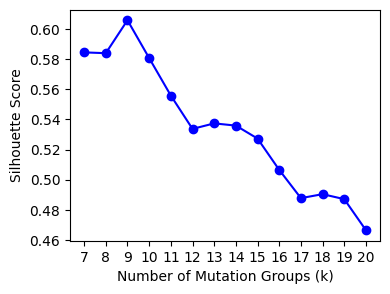

In [8]:
plt.figure(figsize=(4, 3))
plt.plot(k_range, scores, 'bo-')
plt.xlabel('Number of Mutation Groups (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.savefig("../outputs/scope/laks/silouette_scores.svg")

In [9]:
k = 17

idx = np.where(k_range == 17)[0][0]
cluster_labels = cluster_labels_for_all_ks[idx]
cluster_labels

,mutation,mutation_group
0,10:100129846:C:A,4
1,10:100185101:A:G,4
2,10:100209326:T:C,11
3,10:100283942:C:T,16
4,10:10086005:G:T,6
...,...,...
14063,X:98278474:C:A,7
14064,X:98452192:T:C,5
14065,X:98700894:C:T,11
14066,X:99136386:C:T,4


In [10]:
F_bar, F_plus, F_minus = get_cell_fraction_boundaries(F, cluster_labels)
cluster_labels = filter_mutations_with_multiple_subclonality(F_plus, F_minus, F, cluster_labels, threshold=0.2)
cluster_labels.to_csv(f"../outputs/scope/laks/mutation_clusters/kmeans_k_{k}_filtered.csv")
F_bar, F_plus, F_minus = get_cell_fraction_boundaries(F, cluster_labels)

F_plus.to_csv(f"../outputs/scope/laks/mutation_clusters/F_plus.csv")
F_minus.to_csv(f"../outputs/scope/laks/mutation_clusters/F_minus.csv")
F_bar.to_csv(f"../outputs/scope/laks/mutation_clusters/F_bar.csv")


In [11]:
cluster_weights = cluster_labels.groupby("mutation_group").size().tolist()
sum(cluster_weights)

14068

In [12]:
loh_conflicts = pd.read_csv("../data/laks/loh-conflict-counts.csv", index_col=0)
bin_loh_conflicts = (loh_conflicts > 50).astype(int)
bin_loh_conflicts

,A,B,C,D,E,F,G,H,I
A,0,0,1,1,1,1,0,0,0
B,1,0,1,1,1,1,0,0,0
C,1,1,0,0,1,1,0,0,0
D,1,1,0,0,1,1,0,0,0
E,1,1,1,1,0,0,0,0,0
F,1,1,1,1,1,0,0,0,0
G,1,1,1,1,1,1,0,0,0
H,1,1,1,1,1,1,0,0,0
I,1,1,1,1,1,1,0,0,0


In [13]:
forbidden_pairs = []

for i in range(loh_conflicts.shape[0]):
    for j in range(loh_conflicts.shape[1]):
        if bin_loh_conflicts.iloc[i, j] > 0.5: forbidden_pairs.append((j, i))

forbidden_pairs = sorted(forbidden_pairs)

In [14]:
solutions, value = solve_cppme(F_plus, F_minus, cluster_labels, forbidden_pairs)

TRYING 18 CLONES
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2687964
Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Set parameter TimeLimit to value 86400
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  86400

Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Optimize a model with 91697 rows, 7876 columns and 267953 nonzeros
Model fingerprint: 0x17b253fc
Model has 522 quadratic constraints
Variable types: 5121 continuous, 2755 integer (2755 binary)
Coefficient statistics:
  Matrix range     [1e-01, 3e+08]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+01, 2e+01]
  Objective range  [3e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
  QRHS range       

In [15]:
len(solutions)

16

In [17]:
from scope.phylogeny_utils import generate_perfect_phylogeny, draw_clone_tree, add_clusters_to_mutation_T

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


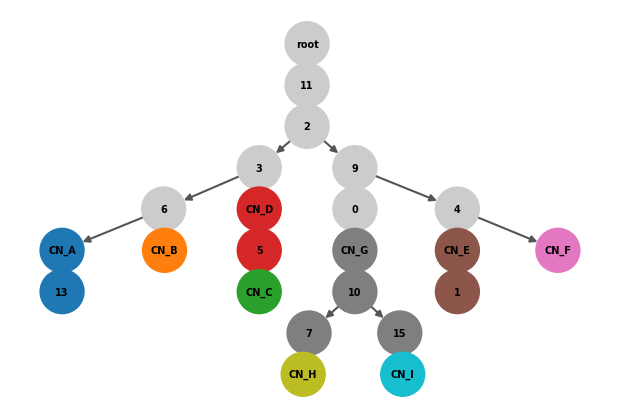

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


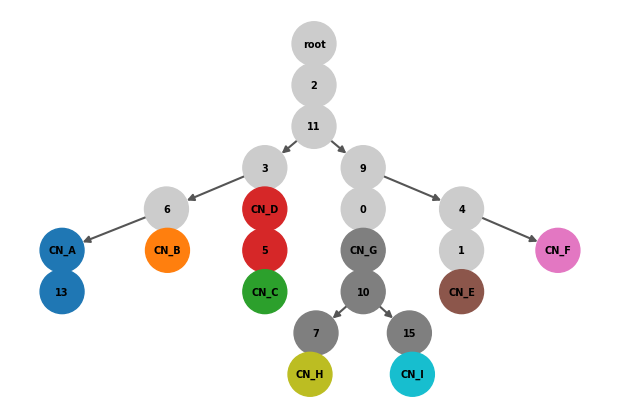

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


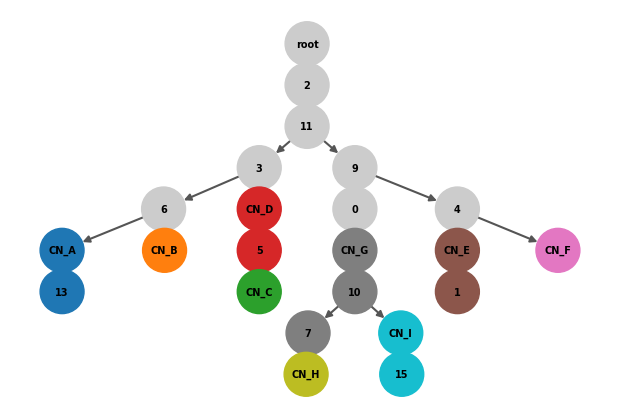

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


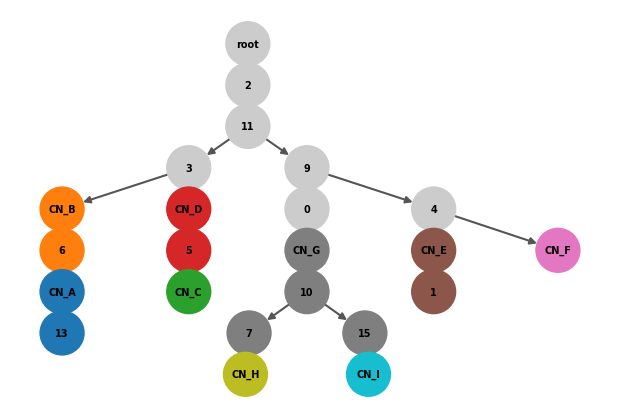

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


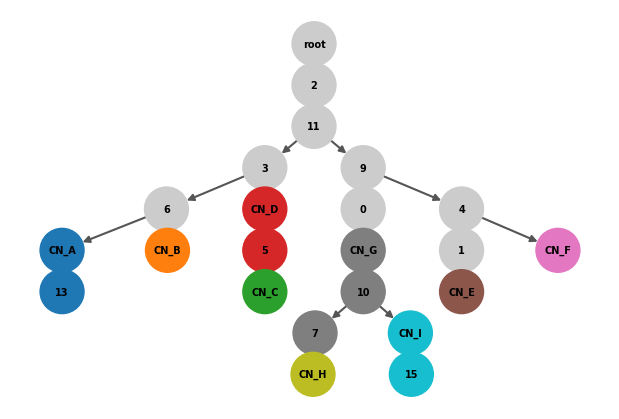

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


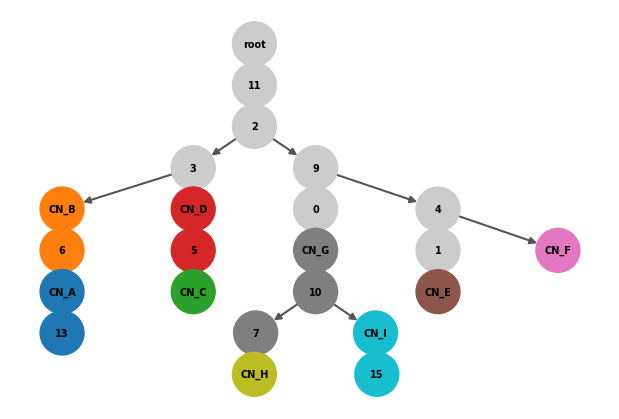

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


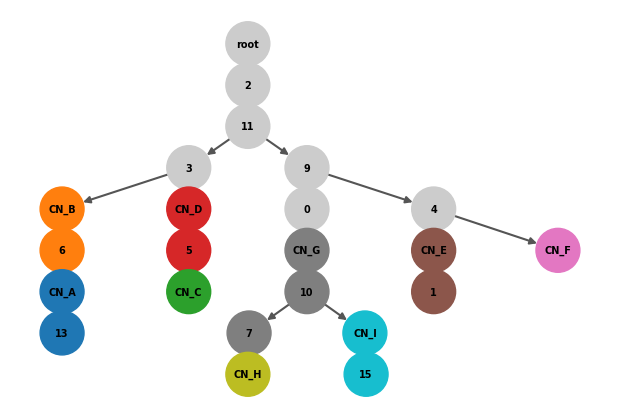

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


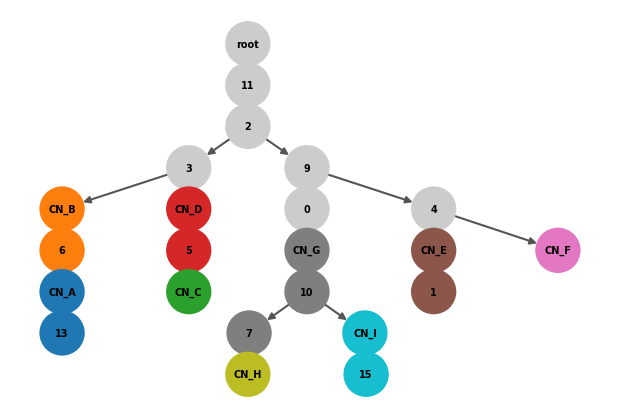

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


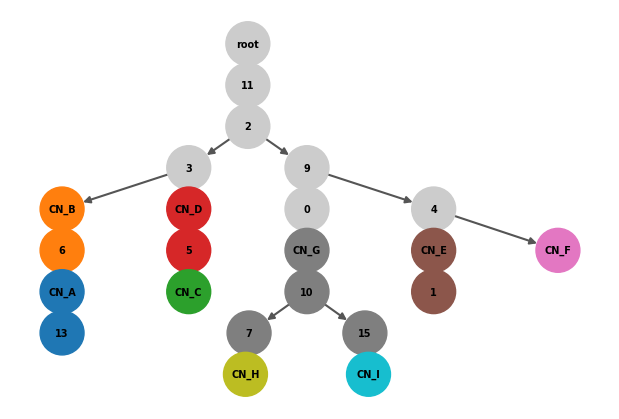

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


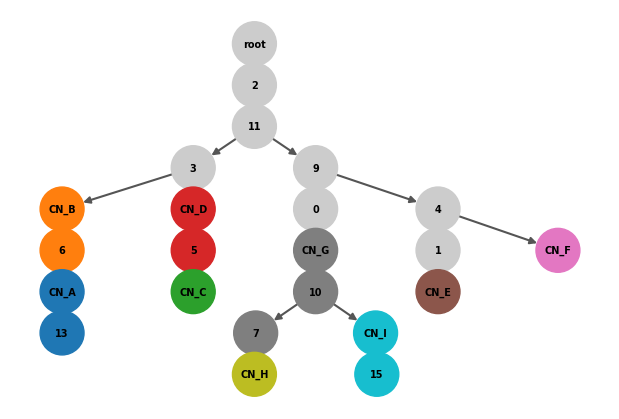

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


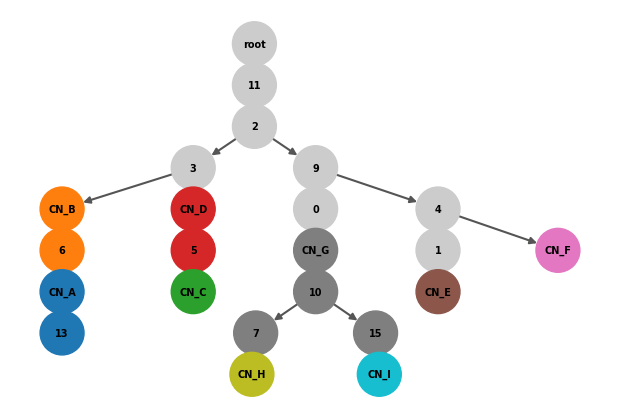

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


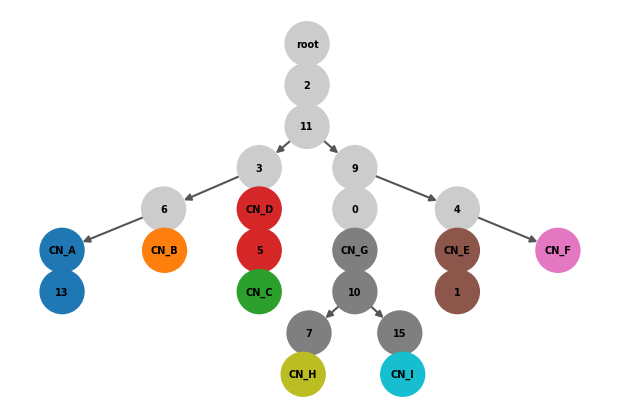

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


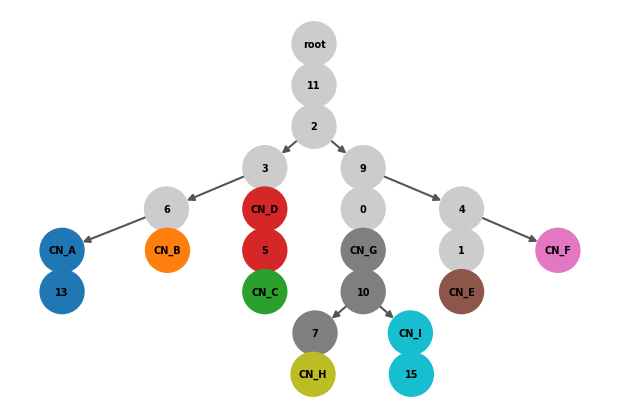

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


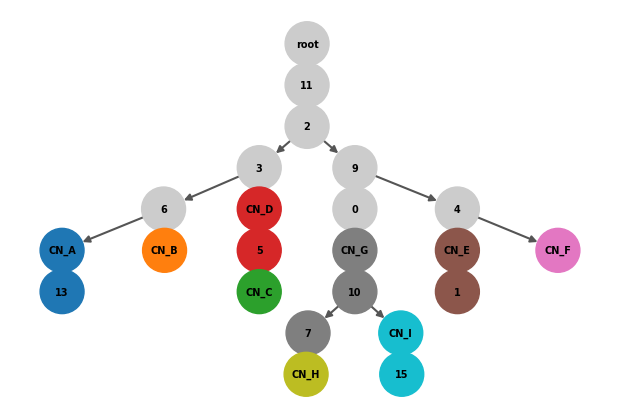

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


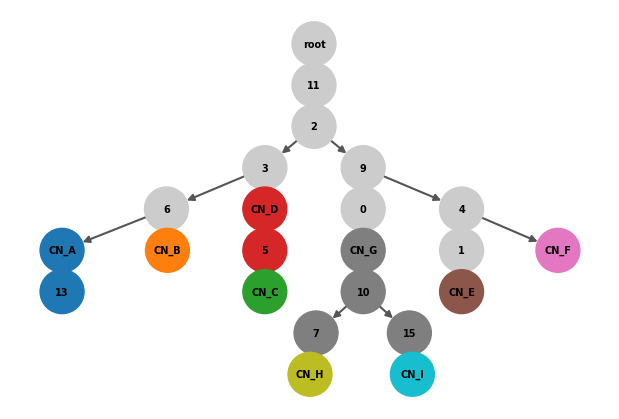

/Users/samin/workspace/scWGS-Tumor-Phylogeny/src/scope/phylogeny_utils.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


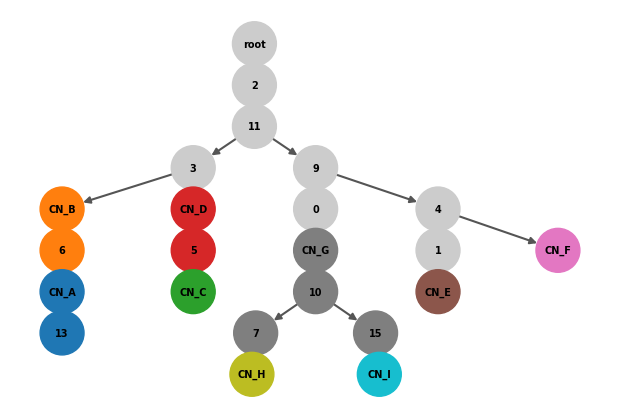

In [18]:
import os

output_prefix = "../outputs/scope/laks/solutions"

unique_solutions = []

for i, solution in enumerate(solutions):
    try:
        solution_path = f"{output_prefix}/solution_{i}"
        os.makedirs(solution_path, exist_ok=True)

        X, B, U, F, G = solution
        
        X.to_csv(f"{solution_path}/X.csv")
        B.to_csv(f"{solution_path}/B.csv")
        U.to_csv(f"{solution_path}/U.csv")
        F.to_csv(f"{solution_path}/F.csv")
        G.to_csv(f"{solution_path}/G.csv")

        S, _ = generate_perfect_phylogeny(B)
        T = add_clusters_to_mutation_T(S, X, G, B)

        draw_clone_tree(T, f"{solution_path}/T.svg")
        draw_clone_tree(T)
        
    except Exception as e:
        print(e)